In [31]:
!pip install nibabel

In [32]:
import os
import random

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import cv2
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader, Dataset
from ipywidgets import IntSlider, interact
from matplotlib import animation, rc
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.path import Path
from scipy import ndimage
from scipy.ndimage import zoom
import torch.nn.functional as F # change

config = {
    'learning_rate': 1e-4,
    'lr_decay_rate': 0.96,
    'epochs': 100,
    'batch_size': 4,
    'img_size': 128,
    'depth': 64
}


In [33]:
def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    min_hu = -1000
    max_hu = 400
    volume[volume < min_hu] = min_hu
    volume[volume > max_hu] = max_hu
    volume = (volume - min_hu) / (max_hu - min_hu)
    return volume.astype('float32')

def resize_volume(img, desired_width=128, desired_height=128, desired_depth=64):
    """Resize the volume"""
    # Compute zoom factors
    width_factor = desired_width / img.shape[0]
    height_factor = desired_height / img.shape[1]
    depth_factor = desired_depth / img.shape[-1]
    # Rotate volume by 90 degrees
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize the volume using spline interpolated zoom (SIZ)
    img = zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path, is_mask_file = False):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume) if not is_mask_file else volume
    # Resize width, height and depth
    volume = resize_volume(
        volume, config['img_size'], config['img_size'], config['depth']
    )
    return volume


In [34]:
# Create directories
output_dir = os.path.join(os.getcwd(), "MosMedData")
os.makedirs(output_dir, exist_ok=True)

test_scan_paths = [os.path.join(output_dir, "CT-1", x) for x in sorted(os.listdir(os.path.join(output_dir, "CT-1")))]
mask_scan_paths = [os.path.join(output_dir, "mask", x) for x in sorted(os.listdir(os.path.join(output_dir, "mask")))]


print("CT scans: " + str(len(test_scan_paths)), test_scan_paths, mask_scan_paths )

CT scans: 7 ['/notebooks/MosMedData/CT-1/study_0255.nii.gz', '/notebooks/MosMedData/CT-1/study_0256.nii.gz', '/notebooks/MosMedData/CT-1/study_0257.nii.gz', '/notebooks/MosMedData/CT-1/study_0258.nii.gz', '/notebooks/MosMedData/CT-1/study_0259.nii.gz', '/notebooks/MosMedData/CT-1/study_0260.nii.gz', '/notebooks/MosMedData/CT-1/study_0939.nii.gz'] ['/notebooks/MosMedData/mask/study_0255_mask.nii.gz', '/notebooks/MosMedData/mask/study_0256_mask.nii.gz', '/notebooks/MosMedData/mask/study_0257_mask.nii.gz', '/notebooks/MosMedData/mask/study_0258_mask.nii.gz', '/notebooks/MosMedData/mask/study_0259_mask.nii.gz', '/notebooks/MosMedData/mask/study_0260_mask.nii.gz']


In [35]:
x_test = np.array([process_scan(path) for path in test_scan_paths])
y_test = np.array([1 for _ in range(len(test_scan_paths))])

print(
    'Number of samples in test are %d'
    % (x_test.shape[0])
)
mask_to_test = mask_scan_paths[0]
test_sample = x_test[0] # width, height, depth
test_tensor = torch.tensor(test_sample).permute(2, 0 ,1) # depth, width, height
print(test_tensor.shape)

Number of samples in test are 7
torch.Size([64, 128, 128])


In [36]:
class Conv3DBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(Conv3DBlock, self).__init__()
        self.conv3d = nn.Conv3d(in_channels, out_channels, kernel_size, padding=1)
        self.activation = nn.ReLU()
        self.pool = nn.MaxPool3d(2)
        self.batchnorm = nn.BatchNorm3d(out_channels)

    def forward(self, x):
        x = self.conv3d(x)
        x = self.activation(x)
        x = self.pool(x)
        x = self.batchnorm(x)
        return x

class CNN3D(nn.Module):
    def __init__(self, width=128, height=128, depth=64):
        super(CNN3D, self).__init__()
        self.conv1 = Conv3DBlock(1, 64)
        self.conv2 = Conv3DBlock(64, 64)
        self.conv3 = Conv3DBlock(64, 128)
        self.conv4 = Conv3DBlock(128, 256)
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc1 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.7)
        self.fc2 = nn.Linear(128, 2) # change
        # self.sigmoid = nn.Sigmoid() # change

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        # x = self.sigmoid(x) # change
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Build model
model = CNN3D().to(device)
print(model)


Using device: cuda
CNN3D(
  (conv1): Conv3DBlock(
    (conv3d): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (activation): ReLU()
    (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batchnorm): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Conv3DBlock(
    (conv3d): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (activation): ReLU()
    (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batchnorm): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Conv3DBlock(
    (conv3d): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (activation): ReLU()
    (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batchnorm): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [37]:
model.load_state_dict(torch.load("3d_image_classification.pth"))
model.eval()

with torch.no_grad():
    sample = test_tensor.unsqueeze(0).unsqueeze(0).to(device, dtype=torch.float32)
    prediction = model(sample)
    print(prediction, prediction.shape) # change
    softmaxed_prediction = F.softmax(prediction, dim=1) # change
    scores = softmaxed_prediction.squeeze().cpu().numpy() # change
    print(scores) # change

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(f"This model is {score * 100:.2f} percent confident that CT scan is {name}")

tensor([[-0.4249,  0.4092]], device='cuda:0') torch.Size([1, 2])
[0.30277658 0.6972234 ]
This model is 30.28 percent confident that CT scan is normal
This model is 69.72 percent confident that CT scan is abnormal


In [38]:
import torch
import torch.nn.functional as F
import numpy as np

def make_diffcam_heatmap(img_tensor, model, last_conv_layer_name, class_idx, ref_class_idx): # change
    """Generate differential class activation heatmap for 3D CNN model"""
    # First, we create a hook to store the activations and gradients
    activations = {}
    gradients = {}
    
    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output # change
        return hook
    
    def get_gradients(name):
        def hook(module, grad_in, grad_out):
            gradients[name] = grad_out[0] # change
        return hook
    
    # Register hooks to capture activations and gradients
    last_conv_layer = dict(model.named_modules())[last_conv_layer_name]
    last_conv_layer.register_forward_hook(get_activation(last_conv_layer_name))
    last_conv_layer.register_backward_hook(get_gradients(last_conv_layer_name))
    
    # Make a forward pass to get predictions and activations
    model.eval()
    output = model(img_tensor)
    
    ## Backward pass to get gradients for target class
    # if pred_index is None:
    #     pred_index = torch.argmax(output, dim=1)
    # class_output = output[:, pred_index].squeeze()
    class_output = output[:, class_idx].squeeze() #change
    model.zero_grad()
    class_output.backward(retain_graph=True)
    # Get the captured gradients and activations
    activations_target = activations[last_conv_layer_name].detach().cpu().numpy()
    gradients_target = gradients[last_conv_layer_name].detach().cpu().numpy()
    
    ## Backward pass to get gradients for reference class
    class_output_ref = output[:, ref_class_idx].squeeze()
    model.zero_grad()
    class_output_ref.backward(retain_graph=True)
    gradients_ref = gradients[last_conv_layer_name].detach().cpu().numpy()
    
     # Compute the differential gradients
    differential_grads = gradients_target - gradients_ref
    
     # Compute the weights
    pooled_grads = np.mean(differential_grads, axis=(0, 2, 3, 4)) # change
    
    # Compute the heatmap
    for i in range(pooled_grads.shape[0]):
        activations_target[:, i, :, :] *= pooled_grads[i]
    heatmap = np.mean(activations_target, axis=1).squeeze()
    
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) # depth, width, height
    heatmap = np.transpose(heatmap, (1,2,0)) # width, height, depth
    print("heatmap", heatmap.shape )
    return heatmap


last_conv_layer_name = 'conv4'
class_idx = 1  # Example target class index
ref_class_idx = 0  # Example reference class index
sample = test_tensor.unsqueeze(0).unsqueeze(0).to(device, dtype=torch.float32)

# Generate class activation heatmap
heatmap = make_diffcam_heatmap(sample, model, last_conv_layer_name, class_idx, ref_class_idx)

print("heatmap generated")

heatmap (8, 8, 4)
heatmap generated


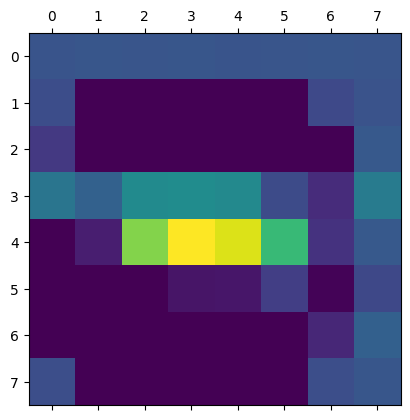

In [39]:
plt.matshow(np.squeeze(heatmap[:, :, 3]))
plt.show()

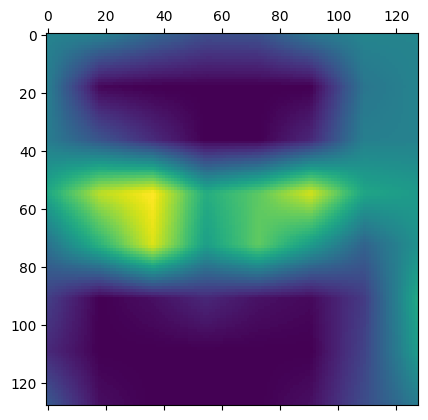

In [40]:
# Resize heatmap

def get_resized_heatmap(heatmap, shape):
    width = shape[0]
    height = shape[1]
    depth = shape[2]
    upscaled_heatmap = zoom(heatmap, (width / heatmap.shape[0], height / heatmap.shape[1], depth / heatmap.shape[2]), order=1)
    upscaled_heatmap = np.uint8(255 * upscaled_heatmap)
    return upscaled_heatmap

resized_heatmap = get_resized_heatmap(heatmap, test_sample.shape)
plt.matshow(np.squeeze(resized_heatmap[:, :, 30]))
plt.show()

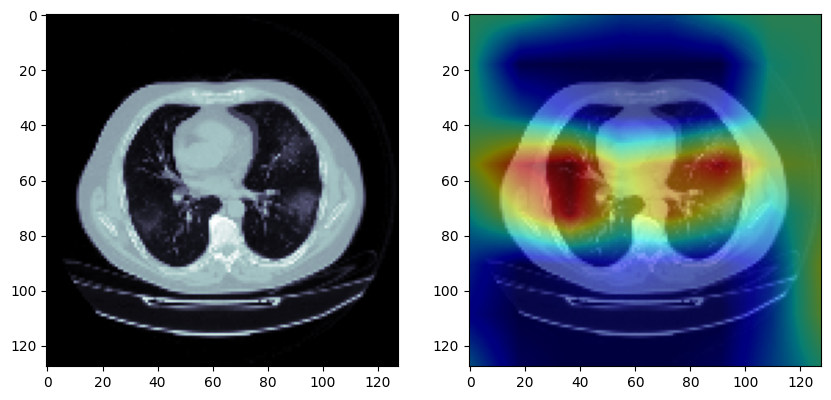

In [41]:
# Visualize heatmap
fig, ax = plt.subplots(1, 2, figsize=(10, 20))

ax[0].imshow(np.squeeze(test_sample[:, :, 30]), cmap='bone')
img0 = ax[1].imshow(np.squeeze(test_sample[:, :, 30]), cmap='bone')
img1 = ax[1].imshow(np.squeeze(resized_heatmap[:, :, 30]), cmap='jet', alpha=0.5, extent=img0.get_extent())
# plt.colorbar()
plt.show()


In [42]:
def read_mask_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan

def resize_mask_volume(img, desired_width=128, desired_height=128, desired_depth=64):
    """Resize the volume"""
    # Compute zoom factors
    width_factor = desired_width / img.shape[0]
    height_factor = desired_height / img.shape[1]
    depth_factor = desired_depth / img.shape[-1]

    # Rotate volume by 90 degrees
    img = ndimage.rotate(img, 90,  axes=(0, 1), reshape=False) # TODO why ??

    # Resize the volume using spline interpolated zoom (SIZ)
    img = zoom(img, (width_factor, height_factor, depth_factor), order=1)

    return img


mask_test_volume = read_mask_nifti_file(mask_to_test)
mask_test_volume = resize_mask_volume(mask_test_volume, config['img_size'], config['img_size'], config['depth'])



8092 [16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54]


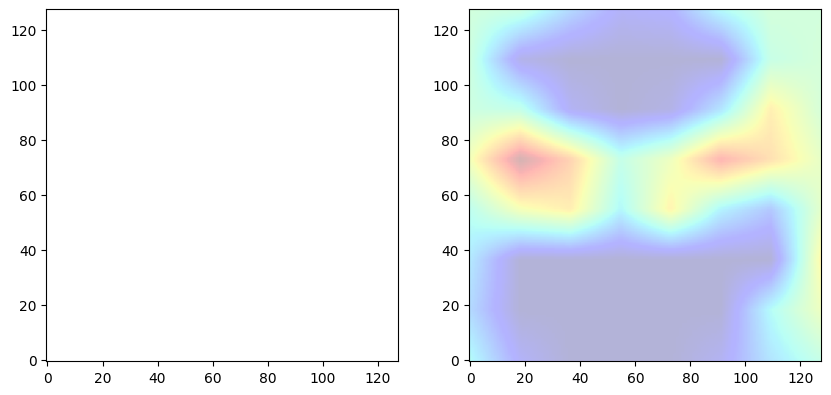

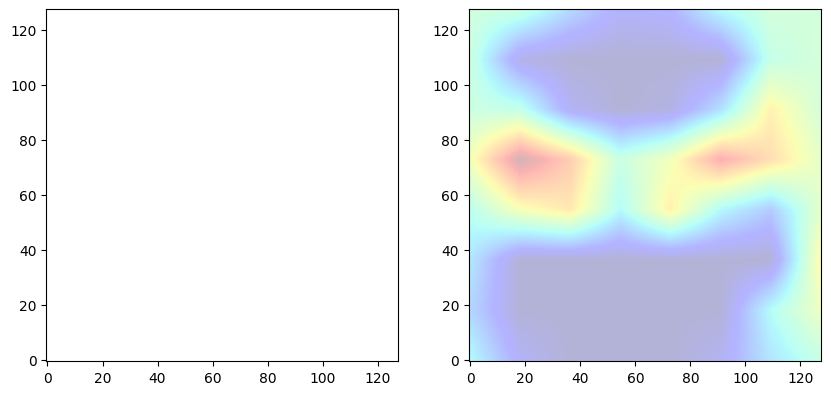

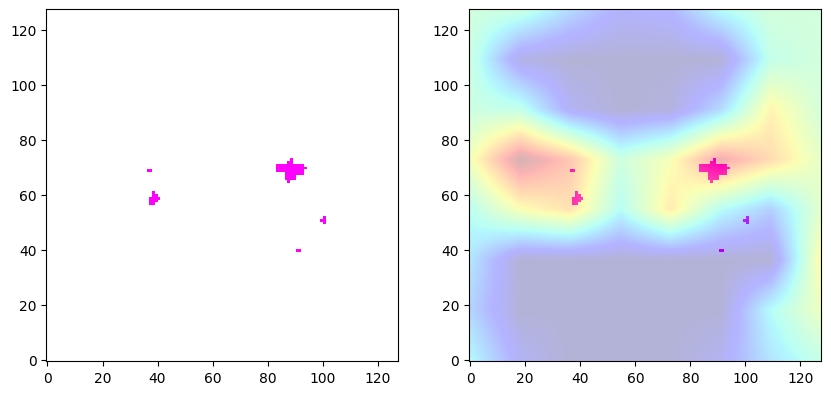

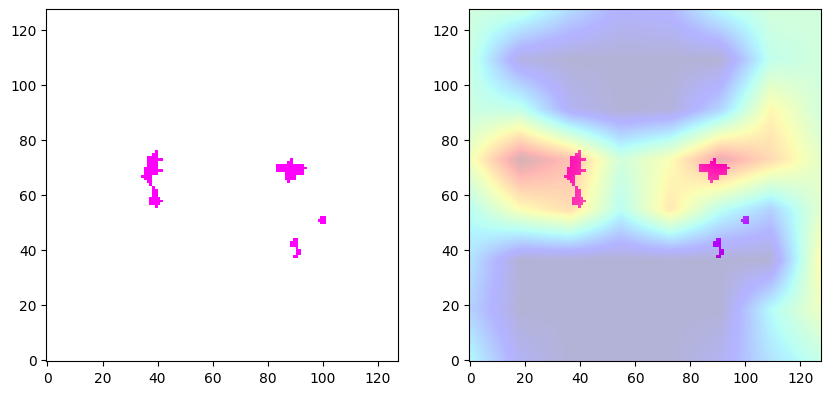

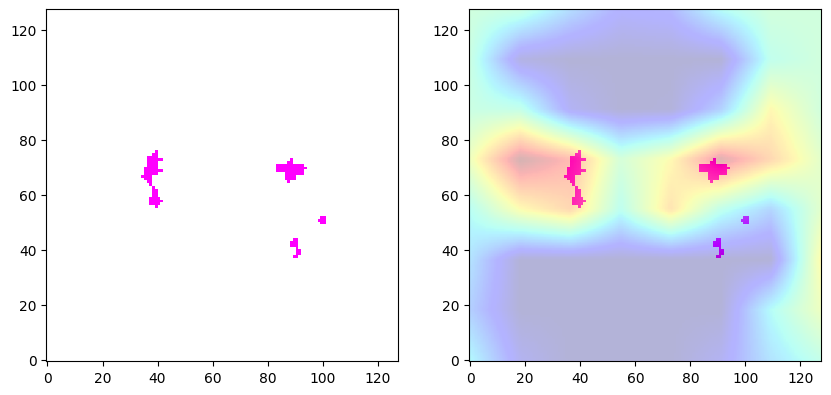

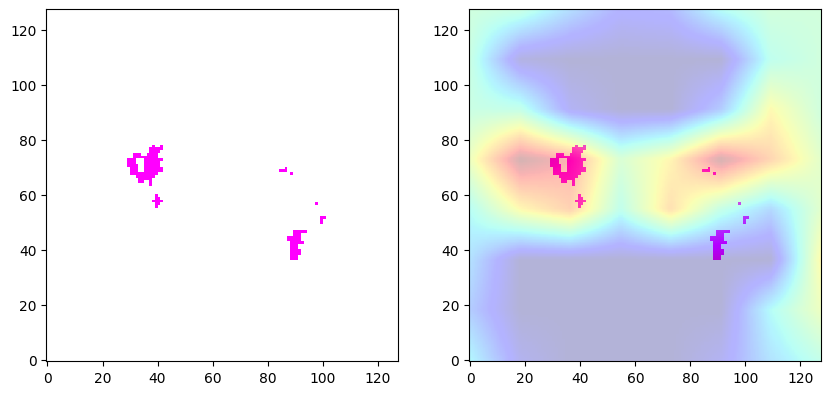

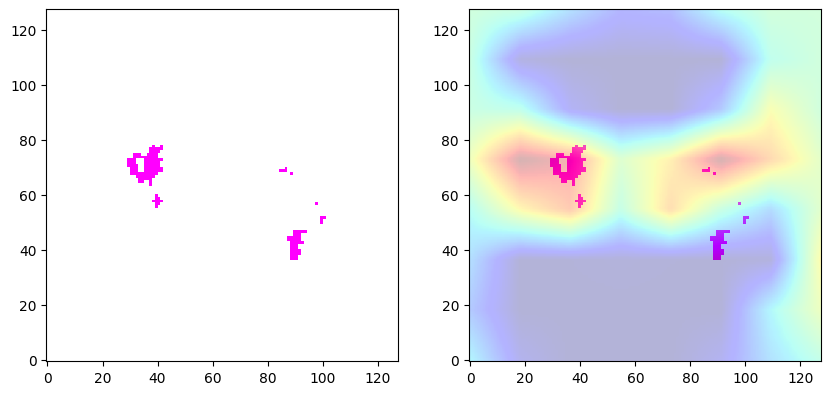

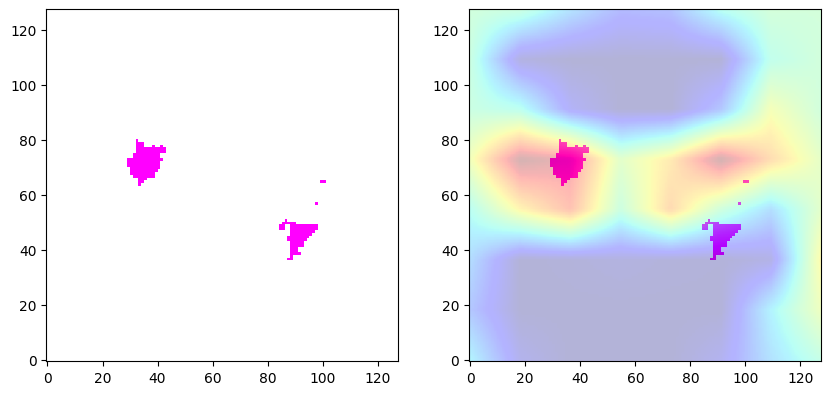

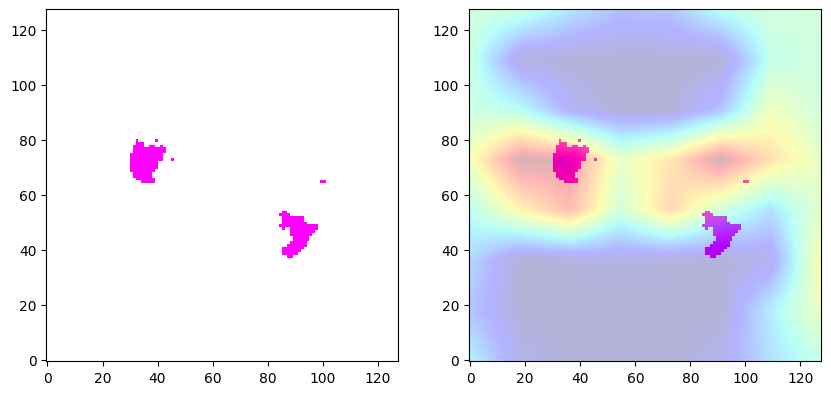

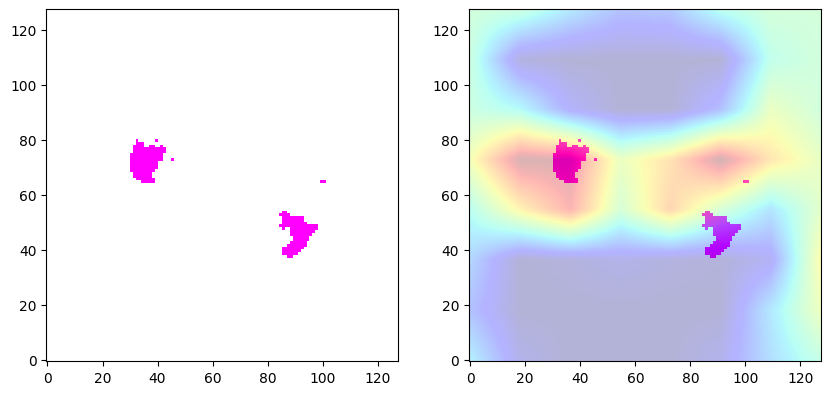

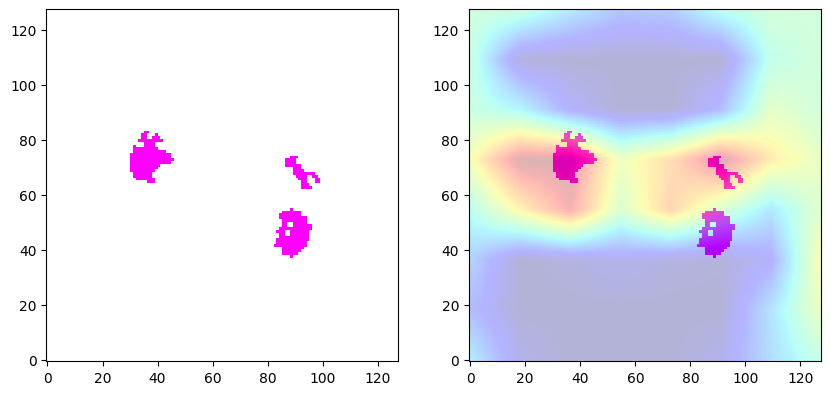

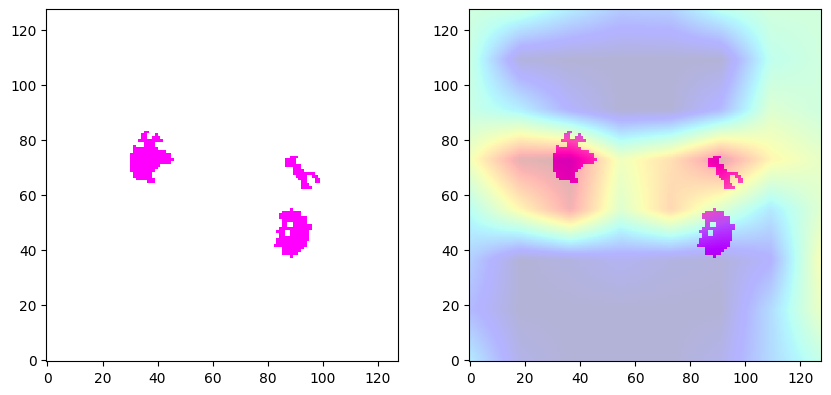

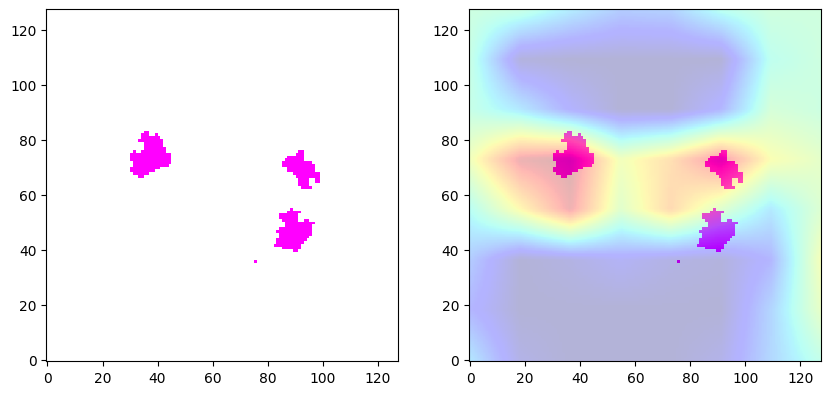

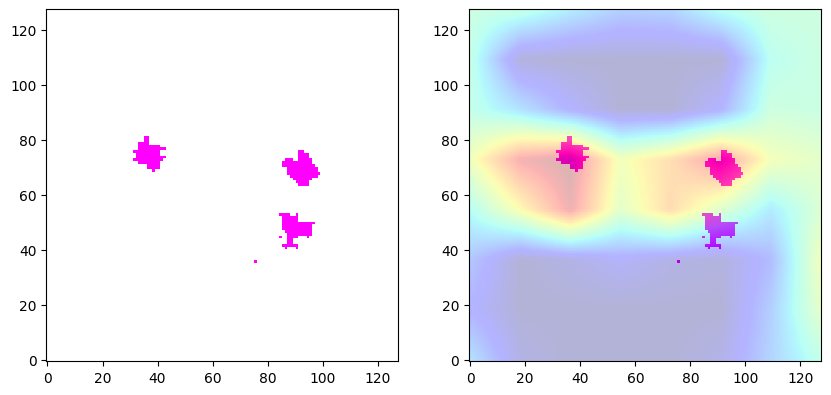

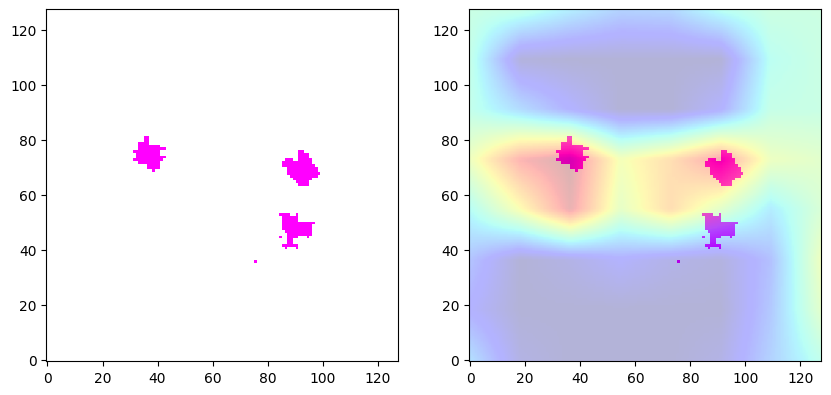

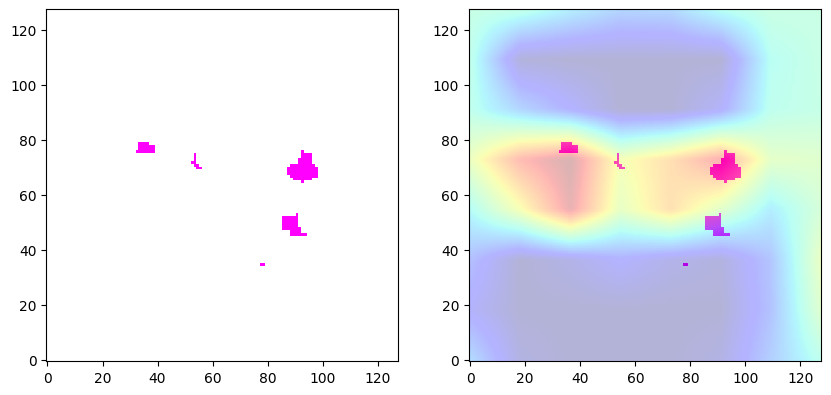

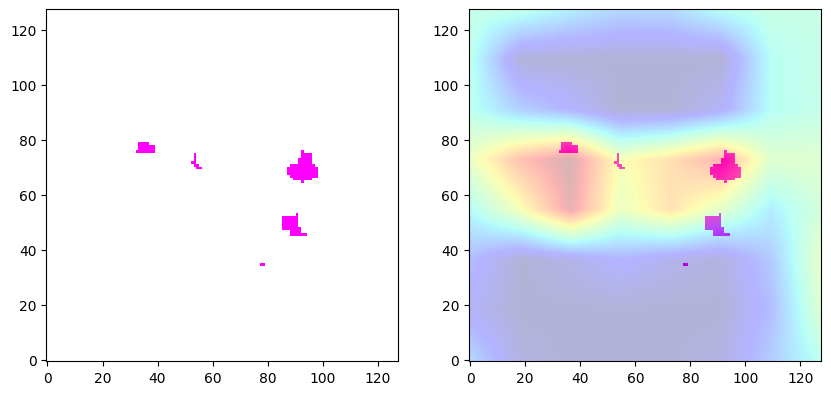

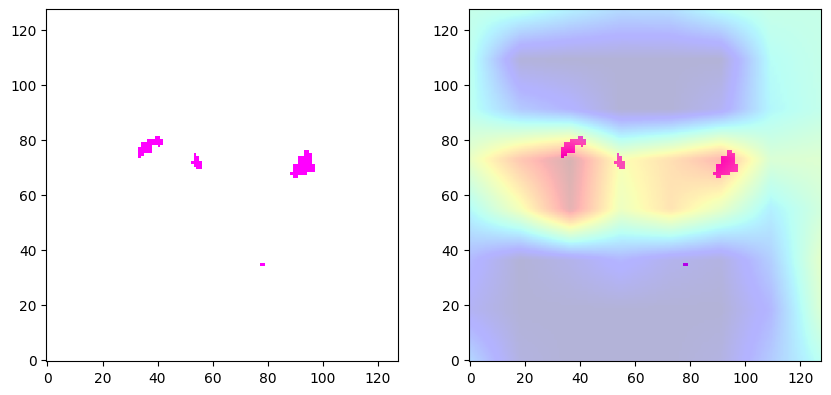

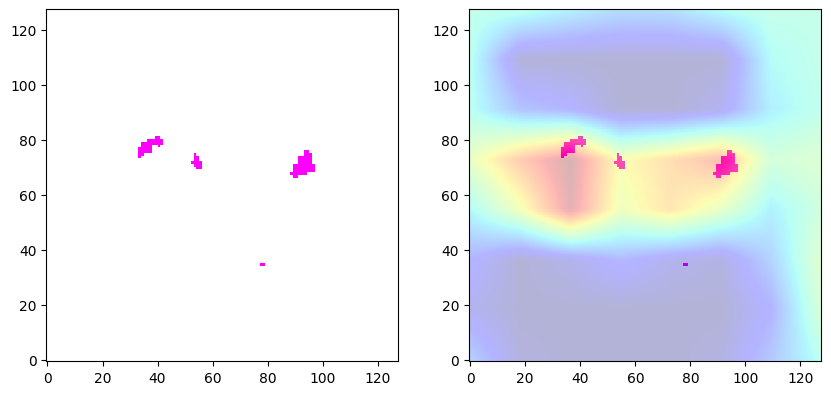

In [ ]:
# Assuming mask values are 0 and 1, convert to yellow (1) and black (0)
mask_test = np.where(np.abs(mask_test_volume) < 1e-15, 0, 1)
indices = np.where(mask_test == 1)
indices_list = list(zip(*indices))
arr = [i[2] for i in indices_list]
print(len(indices_list),np.unique(arr))


mask_test = np.where(mask_test == 1, 1, np.nan)  # Set non-1 values to NaN for transparency

for i in range(np.min(np.unique(arr)),np.max(np.unique(arr))+1):
    fig, ax = plt.subplots(1, 2, figsize=(10, 20))

    ax[0].imshow(np.squeeze(mask_test[:, :, i]),  cmap='spring', origin='lower')
    # img0 = ax[1].imshow(np.squeeze(test_sample[:, :, i]), cmap='bone')
    img1 = ax[1].imshow(np.squeeze(mask_test[:, :, i]),  cmap='spring', origin='lower')
    img2 = ax[1].imshow(np.squeeze(resized_heatmap[:, :, i]), cmap='jet', alpha=0.3, extent=img1.get_extent())

    plt.show()

In [ ]:
mask_test = np.where(np.abs(mask_test_volume) < 1e-15, 0, 1)
indices = np.where(mask_test == 1)
indices_list = list(zip(*indices))
arr = [i[2] for i in indices_list]
print(len(indices_list),np.unique(arr))

# Assuming mask values are 0 and 1, convert to yellow (1) and black (0)

# mask_test = np.where(mask_test == 1, 1, 0)  # Set non-1 values to NaN for transparency
# print(np.unique(mask_test))
mask_test = np.sum(mask_test, axis=2)
print(np.unique(mask_test))
mask_test = np.where(mask_test > 0, 1, np.nan) 
print(np.unique(mask_test))

# mask_test = np.nan_to_num(mask_test, nan=0)
# print(np.unique(mask_test))

fig, ax = plt.subplots(1, 2, figsize=(10, 20))

ax[0].imshow(np.squeeze(mask_test[:, :]),  cmap='spring', origin='lower')
img0 = ax[1].imshow(np.squeeze(mask_test[:, :]),  cmap='spring', origin='lower')
img1 = ax[1].imshow(np.squeeze(resized_heatmap[:, :, 18]), cmap='jet', alpha=0.3, extent=img0.get_extent())

plt.show()


